In [54]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [25]:
# Define the relative paths of the image and annotation folders
train_reid_path = r'dataset\plain_re-ID\atrw_reid_train'
train_anno_reid_path = r'dataset\plain_re-ID\atrw_anno_reid_train\reid_list_train.csv'

test_reid_path = r'dataset\plain_re-ID\atrw_reid_test'
test_anno_reid_path = r'dataset\plain_re-ID\atrw_anno_reid_test\reid_list_test.csv'

# Define the absolute paths of the image and annotation folders
train_reid_path = os.path.abspath(train_reid_path)
train_anno_reid_path = os.path.abspath(train_anno_reid_path)

test_reid_path = os.path.abspath(test_reid_path)
test_anno_reid_path = os.path.abspath(test_anno_reid_path)

# load dataset
data = pd.read_csv(train_anno_reid_path, names=['id', 'image_number'])
X = np.array(data['image_number'])
y = np.array(data['id'])

In [26]:
# Get unique samples
unique_ids = np.unique(y)

# Split unique identifiers
train_ids, test_ids = train_test_split(unique_ids, test_size=0.4, random_state=42)

# Create masks for train and test sets
train_mask = np.isin(y, train_ids)
test_mask = np.isin(y, test_ids)

# Create train and test sets
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

In [27]:
print("The size of trianing dataset: ", len(X_train))
print("The size of testing dataset: ", len(X_test))
print("Number of unique sampels in training dataset: ", len(set(y_train)))
print("Number of unique samples in testing dataset: ", len(set(y_test)))

The size of trianing dataset:  1261
The size of testing dataset:  626
Number of unique sampels in training dataset:  64
Number of unique samples in testing dataset:  43


In [28]:
# Create a mapping from original tiger IDs to sequential numbers
id_to_int = {tiger_id: i for i, tiger_id in enumerate(set(y_train))}
int_to_id = {i: tiger_id for tiger_id, i in id_to_int.items()}

y_train = [id_to_int[id] for id in y_train]

In [29]:
# Create a mapping from original tiger IDs to sequential numbers
id_to_int_test = {tiger_id: i for i, tiger_id in enumerate(set(y_test))}
int_to_id_test = {i: tiger_id for tiger_id, i in id_to_int.items()}

y_test = [id_to_int_test[id] for id in y_test]

In [30]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [31]:
data_transform = transforms.Compose([
    transforms.Lambda(lambda file_path: os.path.join(train_reid_path, file_path)),  
    transforms.Lambda(lambda abs_img_path: Image.open(abs_img_path).convert("RGB")),
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
])

train_dataset = MyDataset(data=X_train, labels=y_train, transform=data_transform)
test_dataset = MyDataset(data=X_train, labels=y_train, transform=data_transform)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Create and train model

In [62]:
# Create the model
resnet_model = resnet50(pretrained=True)

# Freeze layers in the base model
for param in resnet_model.parameters():
    param.requires_grad = False

# Modify the fc layer to match the number of classes in dataset
num_classes = len(set(y_train))
resnet_model.fc = nn.Linear(2048, num_classes)

# fc_layer = nn.Linear(2048, num_classes) 
# softmax_layer = nn.Softmax(dim=1) 

# Replace the fc layer with a sequential layer containing the fc layer and softmax
# resnet_model.fc = nn.Sequential(
#     fc_layer,
#     softmax_layer
# )

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.fc.parameters(), lr=0.001)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Save the model
model_directory_path = os.path.abspath(r'model')
model_path = os.path.join(model_directory_path, 'resnet_50_noSM.h5')
torch.save(resnet_model.state_dict(), model_path)

In [76]:
# Load the trained model from the saved checkpoint
model_directory_path = os.path.abspath(r'model')
model_path = os.path.join(model_directory_path, 'resnet_50_noSM.h5')

model = resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(set(y_train))) 
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

# Make predictions on the testing data
true_labels = []
predicted_labels = []
for images, labels in test_loader:
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy().tolist())
        predicted_labels.extend(preds.cpu().numpy().tolist())

conf_mat = confusion_matrix(true_labels, predicted_labels)
print(conf_mat)

[[20  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 14  0]
 [ 0  0  0 ...  0  0 12]]


In [77]:
# Calculate the accuracy 
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 99.76%


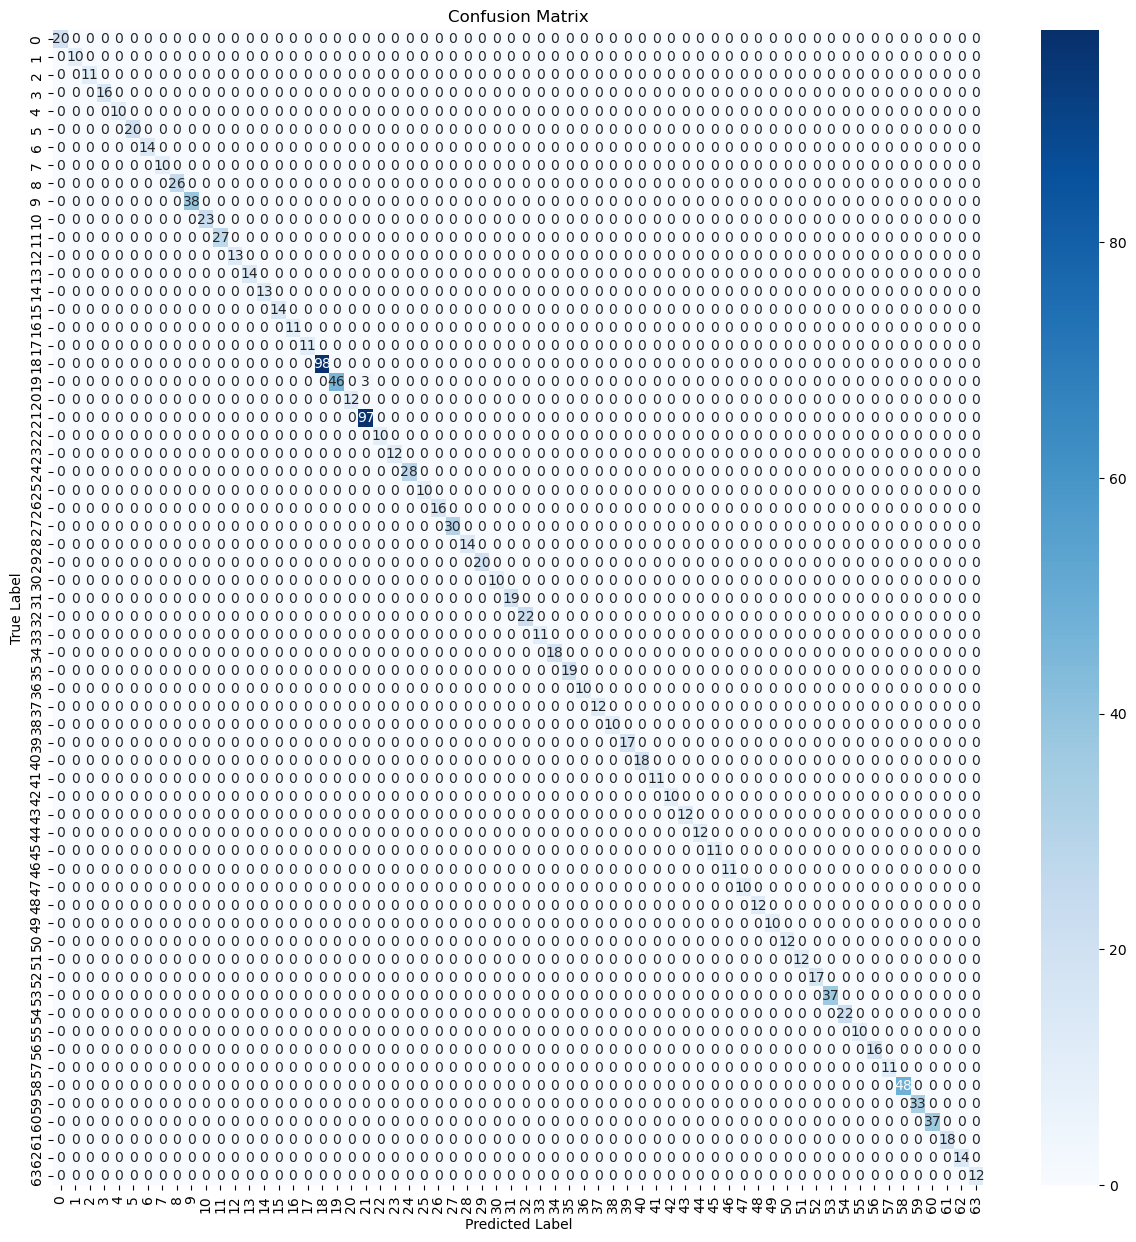

In [65]:
# Visualization of the multiclass classification confusion matrix
# The diagonal elements represent the number of points for which the predicted label is equal to the true label
plt.figure(figsize=(15,15)) 
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [72]:
def compute_AP_and_CMC(rank_list, correct_index):
    CMC = np.zeros_like(rank_list)
    AP = 0.0
    sort_indices = np.argsort(rank_list)[::-1][:20]
    num_positive = len(correct_index)
    
    if num_positive == 0:
        return AP, CMC
    
    hit = 0.0
    for rank, index in enumerate(sort_indices):
        if index in correct_index:
            hit += 1.0
            if hit == 1:
                CMC[rank:] = 1
            AP += hit / (rank+1) 
    AP /= num_positive
    return AP, CMC

# Compute and save features and labels for all images in the test dataset
gallery_labels = []
gallery_outputs = []
for images, labels in test_loader:
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        gallery_labels.extend(labels.cpu().numpy().tolist())
        gallery_outputs.extend(outputs.cpu().numpy())

# Convert lists to numpy arrays for easier manipulation
gallery_labels = np.array(gallery_labels)
gallery_outputs = np.array(gallery_outputs)

APs = []
CMCs = []

# Now we iterate over the test_loader again, this time treating each image as a query image
for i, (query_image, query_label) in enumerate(test_loader.dataset):
    query_image = query_image.to(device).unsqueeze(0)
    with torch.no_grad():
        query_output = model(query_image)

        scores = np.dot(query_output, gallery_outputs.T).squeeze(0)

        scores = np.delete(scores, i)
        labels_i = np.delete(gallery_labels, i)

        correct_indices = np.where(labels_i == query_label)[0]
        AP, CMC = compute_AP_and_CMC(scores, correct_indices)
        APs.append(AP)
        CMCs.append(CMC)

mAP = np.mean(APs)
mean_CMC = np.mean(np.vstack(CMCs), axis=0)

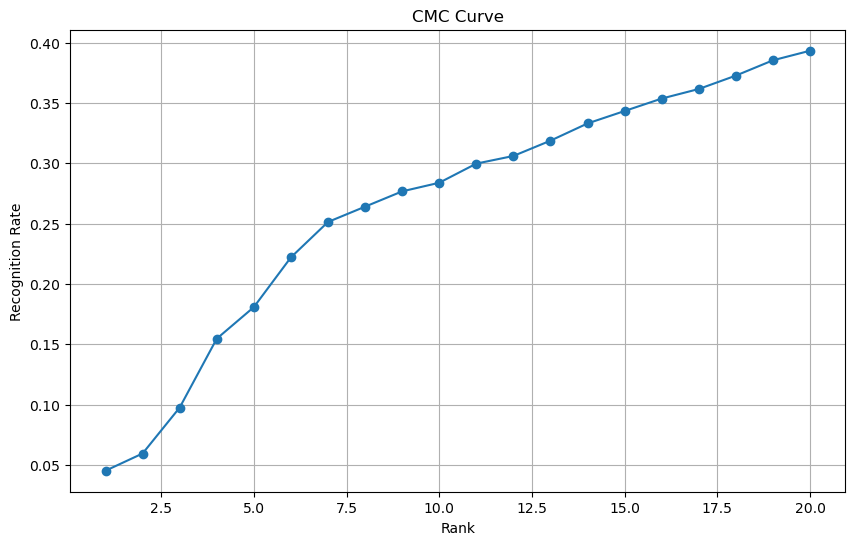

The mAP: 1.33%


In [74]:
ranks = list(range(1, len(mean_CMC) + 1))

plt.figure(figsize=(10, 6))
num_ranks = min(20, len(mean_CMC))
plt.plot(range(1, num_ranks + 1), mean_CMC[:20], marker='o')
plt.xlabel('Rank')
plt.ylabel('Recognition Rate')
plt.title('CMC Curve')
plt.grid(True)
plt.show()

print(f'The mAP: {mAP*100:.2f}%')